In [1]:
import torchaudio
import torch
import os

%load_ext autoreload
%autoreload 2

In [2]:
# load file at data/vcc2016_training/SF1/100001.wav
waveform, sample_rate = torchaudio.load('../data/vcc2016_training/SF1/100001.wav')
waveform.size()

torch.Size([1, 56314])

In [141]:
class Downsample(torch.nn.Module):
   
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
      super(Downsample, self).__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.conv = torch.nn.Conv1d(in_channels=in_channels,
                                  out_channels=out_channels,
                                  kernel_size=kernel_size,
                                  stride=stride,
                                  padding=padding)
      self.norm = torch.nn.InstanceNorm1d(num_features=out_channels, affine=True)
      self.glu = torch.nn.GLU(dim=1)
    
    def forward(self, x):
      """ [B, D, T] -> [B, D, T]"""
      x = self.conv(x)
      x = self.norm(x)
      x = self.glu(x)
      return x
  
class ResidualBlock(torch.nn.Module):
  def __init__(self, in_channels1, out_channels1, in_channels2, out_channels2, kernel_size, stride):
    super(ResidualBlock, self).__init__()
    self.conv1 = torch.nn.Conv1d(in_channels=in_channels1,
                                out_channels=out_channels1,
                                kernel_size=kernel_size,
                                stride=stride,
                                padding='same')
    self.norm1 = torch.nn.InstanceNorm1d(num_features=out_channels1, affine=True)
    self.glu = torch.nn.GLU(dim=1)
    self.conv2 = torch.nn.Conv1d(in_channels=in_channels2,
                                out_channels=out_channels2,
                                kernel_size=kernel_size,
                                stride=stride,
                                padding='same')
    self.norm2 = torch.nn.InstanceNorm1d(num_features=out_channels2, affine=True)
  
  def forward(self, x):
    """ [B, D, T] -> [B, D, T]"""
    residual = x.clone()
    x = self.conv1(x)
    x = self.norm1(x)
    x = self.glu(x)
    x = self.conv2(x)
    x = self.norm2(x)
    return x + residual

# from https://github.com/serkansulun/pytorch-pixelshuffle1d
class PixelShuffle1D(torch.nn.Module):
    """
    1D pixel shuffler. https://arxiv.org/pdf/1609.05158.pdf
    Upscales sample length, downscales channel length
    "short" is input, "long" is output
    """
    def __init__(self, upscale_factor):
        super(PixelShuffle1D, self).__init__()
        self.upscale_factor = upscale_factor

    def forward(self, x):
        """ [B, D, T] -> [B, D/upscale_factor, T*upscale_factor]"""
        batch_size = x.shape[0]
        short_channel_len = x.shape[1]
        short_width = x.shape[2]

        long_channel_len = short_channel_len // self.upscale_factor
        long_width = self.upscale_factor * short_width

        x = x.contiguous().view([batch_size, self.upscale_factor, long_channel_len, short_width])
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(batch_size, long_channel_len, long_width)

        return x

class Upsample(torch.nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=(0, 0)):
      super(Upsample, self).__init__()
      self.conv = torch.nn.Conv1d(in_channels=in_channels,
                                          out_channels=out_channels,
                                          kernel_size=kernel_size,
                                          stride=stride,
                                          padding=padding)
      self.pixel_shuffle = PixelShuffle1D(upscale_factor=2)
      self.norm = torch.nn.InstanceNorm1d(num_features=out_channels//2, affine=True)
      self.glu = torch.nn.GLU(dim=1)
    
    def forward(self, x):
      x = self.conv(x)
      x = self.pixel_shuffle(x)
      x = self.norm(x)
      x = self.glu(x)
      return x

class Generator(torch.nn.Module):
    
    def __init__(self):
      super(Generator, self).__init__()
      self.conv1 = torch.nn.Conv1d(in_channels=24, out_channels=128, kernel_size=5, stride=1, padding=2)
      self.glu = torch.nn.GLU(dim=1)
      self.downsample_twice = torch.nn.Sequential(
        Downsample(in_channels=64, out_channels=256, kernel_size=5, stride=2, padding=2),
        Downsample(in_channels=128, out_channels=512*2, kernel_size=5, stride=2, padding=2),
      )
      self.residual_blocks = torch.nn.Sequential(
        *[ResidualBlock(in_channels1=512, out_channels1=1024,
                        in_channels2=512, out_channels2=512,
                        kernel_size=3, stride=1) for _ in range(6)]
      )
      self.upsample_twice = torch.nn.Sequential(
         Upsample(in_channels=512, out_channels=1024, kernel_size=5, stride=1, padding=2),
         Upsample(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=2),
      )
      self.conv2 = torch.nn.Conv1d(in_channels=128, out_channels=24, kernel_size=15, stride=1, padding='same')

    def forward(self, x):
      """ [B, D, T] -> [B, D, T]
      B - batch size
      D - number of mel-cepstral coefficients
      T - number of time steps - 128 for training
      """
      x = self.conv1(x)
      x = self.glu(x)
      x = self.downsample_twice(x)
      x = self.residual_blocks(x)
      x = self.upsample_twice(x)
      x = self.conv2(x)
      return x

class Downsample2d(torch.nn.Module):
   
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=[0, 0]):
      super(Downsample2d, self).__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.conv = torch.nn.Conv2d(in_channels=in_channels,
                                  out_channels=out_channels,
                                  kernel_size=kernel_size,
                                  stride=stride,
                                  padding=padding)
      self.norm = torch.nn.InstanceNorm2d(num_features=out_channels, affine=True)
      self.glu = torch.nn.GLU(dim=1)
    
    def forward(self, x):
      """ [B, D, T] -> [B, D, T]"""
      x = self.conv(x)
      x = self.norm(x)
      x = self.glu(x)
      return x

class Discriminator(torch.nn.Module):
   
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=128, kernel_size=(3, 3), stride=(1, 2), padding=(1,1))
    self.glu = torch.nn.GLU(dim=1)
    
    self.d1 = Downsample2d(in_channels=64, out_channels=256, kernel_size=(3, 3), stride=(2, 2), padding=(1,1))
    self.d2 = Downsample2d(in_channels=128, out_channels=512, kernel_size=(3, 3), stride=(2, 2), padding=(1,1))
    self.d3 = Downsample2d(in_channels=256, out_channels=1024, kernel_size=(6, 3), stride=(1, 2), padding=(0,0))
    
    self.fc = torch.nn.Linear(in_features=3584, out_features=1)
    self.sigmoid = torch.nn.Sigmoid()     

  def forward(self, x):
    x = self.conv1(x)
    x = self.glu(x)
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    x = x.flatten(start_dim=1)
    x = self.fc(x)
    x = self.sigmoid(x)
    return x

In [151]:
def test_residual_block():
  residual = ResidualBlock(in_channels1=1024, out_channels1=1024, 
              in_channels2=512, out_channels2=1024,
              kernel_size=3, stride=1)

  residual.forward(torch.randn(1, 1024, 1024)).size()
test_residual_block()

def test_downsample_block():
  downsample = Downsample(in_channels=24, out_channels=256, kernel_size=5, stride=2)
  print(downsample.forward(torch.randn(1, 24, 1024)).size())
test_downsample_block()

def test_upsample_block():
  upsample1 = Upsample(in_channels=512, out_channels=1024, kernel_size=5, stride=1, padding=2)
  upsample2 = Upsample(in_channels=256, out_channels=512, kernel_size=5, stride=1, padding=2)
  x = torch.randn(1, 512, 1024)
  x = upsample1.forward(x)
  x = upsample2.forward(x)
test_upsample_block()

def test_generator():
  generator = Generator()
  print(generator.forward(torch.randn(1, 24, 128)).size())
test_generator()

def test_discriminator():
  discriminator = Discriminator()
  print(discriminator.forward(torch.randn(1, 1, 24, 128)).size())
test_discriminator()

torch.Size([1, 128, 510])
torch.Size([1, 24, 128])
torch.Size([1, 1])


In [143]:
class CycleGAN(torch.nn.Module):
      
      def __init__(self):
        super(CycleGAN, self).__init__()
        self.Gx_y = Generator()
        self.Gy_x = Generator()
        self.Dy = Discriminator()
        self.Dx = Discriminator()

In [155]:
def test_cyclegan():
  cycleGAN = CycleGAN()

  # Forward-inverse mapping
  x = torch.randn(1, 24, 128)
  y_hat = cycleGAN.Gx_y.forward(x)
  print(f'y_hat: {y_hat.size()}')

  x_hat = cycleGAN.Gy_x.forward(y_hat)

  print(f'x_hat: {x_hat.size()}')
  x_hat = x_hat.unsqueeze(0)
  print(f'x_hat: {x_hat.size()}')

  print(f'Dy: {cycleGAN.Dy.forward(x_hat).size()}')

  # Inverse-forward mapping
  y = torch.randn(1, 24, 128)
  x_hat = cycleGAN.Gy_x.forward(y)
  y_hat = cycleGAN.Gx_y.forward(x_hat)

  x_hat = x_hat.unsqueeze(0)

  cycleGAN.Dx.forward(x_hat).size()

test_cyclegan()

y_hat: torch.Size([1, 24, 128])
x_hat: torch.Size([1, 24, 128])
x_hat: torch.Size([1, 1, 24, 128])
Dy: torch.Size([1, 1])


Epoch 0


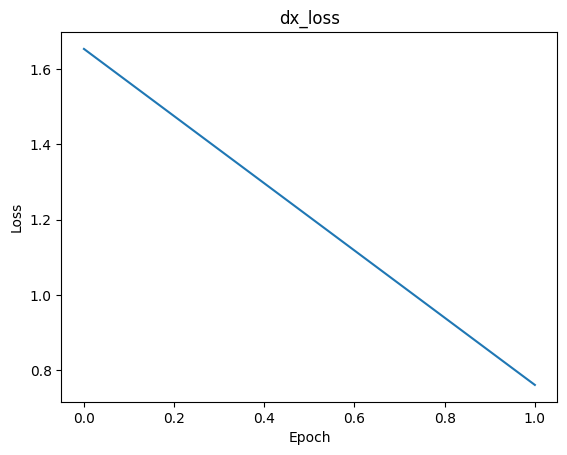

In [159]:
def training_iteration(features,
                       optimizer_Dx, optimizer_Dy,
                       optimizer_Gx_y, optimizer_Gy_x,
                       criterion, Gx_y, Gy_x, Dx, Dy):
  # A batch of training features
  batch_size = features.size()[0]
  # Create labels which are later used as input for the BCU loss
  real_labels = torch.ones(batch_size, 1)
  fake_labels = torch.zeros(batch_size, 1)

  # ======================================================== #
  #                      TRAIN DISCRIMINATORS                #
  # ======================================================== #

  def adversarial_loss(G, D, features):

    # Discriminator should learn to classify real and fake features
    # correctly. Thus we give it a set for real features with real labels
    # and a set of fake features with fake labels.
    outputs = D.forward(features.unsqueeze(0))
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Generate fake features
    # from IPython.core.debugger import Tracer; Tracer()() 
    z = torch.randn(features.shape).to(device)
    fake_features = G.forward(z)
    outputs = D.forward(fake_features.unsqueeze(0))
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = d_loss_real + d_loss_fake
    return d_loss, real_score, fake_score

  # Train Dx
  dx_loss, real_score, fake_score = adversarial_loss(G=Gx_y, D=Dx, features=features)
  optimizer_Dx.zero_grad()
  optimizer_Gx_y.zero_grad()
  dx_loss.backward()
  optimizer_Dx.step()

  # Train Dy
  dy_loss, real_score, fake_score = adversarial_loss(G=Gy_x, D=Dy, features=features)
  optimizer_Dy.zero_grad()
  optimizer_Gy_x.zero_grad()
  dy_loss.backward()
  optimizer_Dy.step()

  # ======================================================== #
  #                      TRAIN GENERATORS                    #
  # ======================================================== #

  def cycle_consistency_loss(Gx_y, Gy_x, features, cyc_tradeoff_parameter):
    forward_loss = torch.norm(Gy_x.forward(Gx_y.forward(features)) - features)
    inverse_forward_loss = torch.norm(Gx_y.forward(Gy_x.forward(features)) - features)
    return cyc_tradeoff_parameter * (forward_loss + inverse_forward_loss)
  
  def identity_loss(Gx_y, Gy_x, features, identity_tradeoff_parameter):
    return identity_tradeoff_parameter * (torch.norm(Gx_y.forward(features) - features) + torch.norm(Gy_x.forward(features) - features))
  
  def generator_loss(Gx_y, Gy_x, features, cyc_tradeoff_parameter, identity_tradeoff_parameter):
    return cycle_consistency_loss(Gx_y=Gx_y, Gy_x=Gy_x, features=features, cyc_tradeoff_parameter=cyc_tradeoff_parameter) + \
      identity_loss(Gx_y=Gx_y, Gy_x=Gy_x, features=features, identity_tradeoff_parameter=identity_tradeoff_parameter)
  
  # Train Gx_y
  gx_y_loss = generator_loss(Gx_y=Gx_y, Gy_x=Gy_x, features=features, cyc_tradeoff_parameter=0.5, identity_tradeoff_parameter=0.5)
  optimizer_Gx_y.zero_grad()
  gx_y_loss.backward()
  optimizer_Gx_y.step()

  # Train Gy_x
  gy_x_loss = generator_loss(Gx_y=Gx_y, Gy_x=Gy_x, features=features, cyc_tradeoff_parameter=0.5, identity_tradeoff_parameter=0.5)
  optimizer_Gy_x.zero_grad()
  gy_x_loss.backward()
  optimizer_Gy_x.step()

  # Return all losses
  return dx_loss, dy_loss, gx_y_loss, gy_x_loss 

device = 'cpu'

batch_size=1
cycleGAN = CycleGAN()
cycleGAN.to(device)

optimizer_Dx=torch.optim.Adam(cycleGAN.Dx.parameters(), lr=0.0002)
optimizer_Dy=torch.optim.Adam(cycleGAN.Dy.parameters(), lr=0.0002)
optimizer_Gx_y=torch.optim.Adam(cycleGAN.Gx_y.parameters(), lr=0.0002)
optimizer_Gy_x=torch.optim.Adam(cycleGAN.Gy_x.parameters(), lr=0.0002)
criterion=torch.nn.BCELoss()
features = torch.randn(1, 24, 128).to(device)

def train(num_epochs):
  epochs = []
  losses = []

  for epoch in range(num_epochs):
    if epoch % 10 == 0:
      print(f'Epoch {epoch}')
    loss = training_iteration(
      features=features,
      optimizer_Dx=optimizer_Dx,
      optimizer_Dy=optimizer_Dy,
      optimizer_Gx_y=optimizer_Gx_y,
      optimizer_Gy_x=optimizer_Gy_x,
      criterion=criterion,
      Gx_y=cycleGAN.Gx_y,
      Gy_x=cycleGAN.Gy_x,
      Dx=cycleGAN.Dx,
      Dy=cycleGAN.Dy,
    )
    epochs.append(epoch)
    losses.append(loss[0].item())

  import matplotlib.pyplot as plt
  plt.plot(epochs, losses)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('dx_loss')
  plt.show()

train(num_epochs = 2)

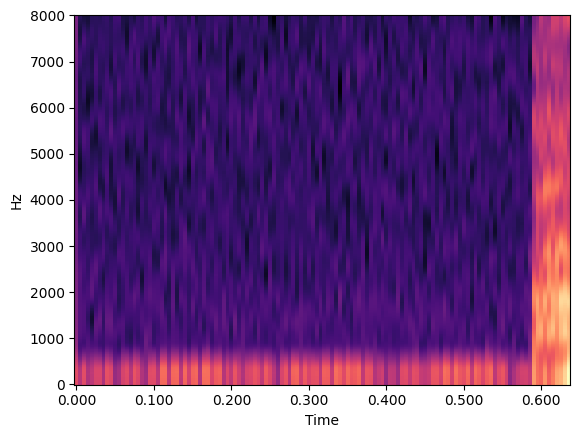

In [160]:
import numpy as np
from dataloader import AudioDataset
from torch.utils.data import DataLoader
import librosa

def test_dataset():
    dataset = AudioDataset('../data/vcc2016_training', batch_size=1, sr=16000)
    sample = dataset[0]

    sp = sample[0][2].squeeze()
    fs = 16000
    frame_period = 5.0

    # Use this in Ipython to see plot
    librosa.display.specshow(np.log(sp).T,
                            sr=fs,
                            hop_length=int(0.001 * fs * frame_period),
                            x_axis="time",
                            y_axis="linear",
                            cmap="magma")

test_dataset()


In [165]:
from dataloader import AudioDataset
from torch.utils.data import DataLoader

dataset = AudioDataset('../data/vcc2016_training', batch_size=1, sr=16000)
train_dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1)

def train():
  iterator = iter(train_dataloader)

  iteration = 0
  for _ in range(10):
    batch = next(iterator)
    print(f'iteration {iteration}')
    
    # convert to float32 because model is defined this way
    source_features = batch[0][-1].to(dtype=torch.float32).transpose(0, 1)
    target_features = batch[1][-1].to(dtype=torch.float32).transpose(0, 1)
    print(source_features.size())
    print(target_features.size()

    loss1, loss2, loss3, loss4 = training_iteration(features=source_features,
                        optimizer_Dx=optimizer_Dx,
                        optimizer_Dy=optimizer_Dy,
                        optimizer_Gx_y=optimizer_Gx_y,
                        optimizer_Gy_x=optimizer_Gy_x,
                        criterion=criterion,
                        Gx_y=cycleGAN.Gx_y,
                        Gy_x=cycleGAN.Gy_x,
                        Dx=cycleGAN.Dx,
                        Dy=cycleGAN.Dy)

    print(f'loss1: {loss1}')
    print(f'loss2: {loss2}')
    print(f'loss3: {loss3}')
    print(f'loss4: {loss4}')
    iteration += 1

train()

iteration 0


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 128, 1, 24]

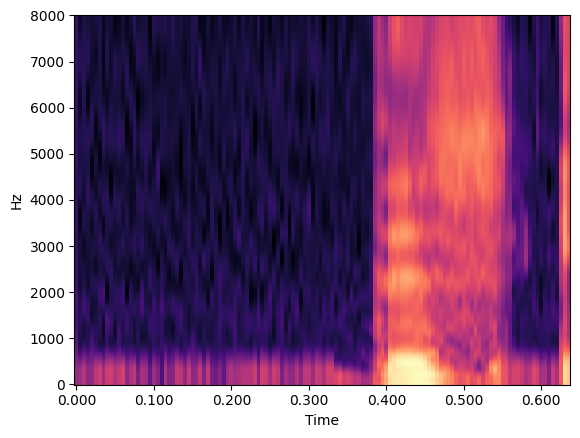

In [100]:
import pyworld as pw

batch = next(iter(train_dataloader))
source_features = batch[0]
source_mcep = source_features[-1]
source_mcep = source_mcep.to(dtype=torch.float32).transpose(-2, -1).unsqueeze(2)
output_mcep = cycleGAN.Gx_y.forward(source_mcep)

def render_sp(sp, fs, frame_period):
  # Use this in Ipython to see plot
  librosa.display.specshow(np.log(sp).T,
                          sr=fs,
                          hop_length=int(0.001 * fs * frame_period),
                          x_axis="time",
                          y_axis="linear",
                          cmap="magma")


def render_mcep_features(features, mcep):
  # Convert source mel-cepstral coefficients to spectrogram
  f0 = features[0].numpy()
  time_axis = features[1].numpy()
  ap = features[3].numpy()
  fs = 16000
  mcep = mcep.squeeze().transpose(-2, -1).to(dtype=torch.float64).contiguous()

  sp = pw.decode_spectral_envelope(mcep.numpy(), fs, fft_size=1024)

  frame_period = 5.0

  render_sp(sp, fs, frame_period)

render_mcep_features(features=source_features, mcep=source_mcep)

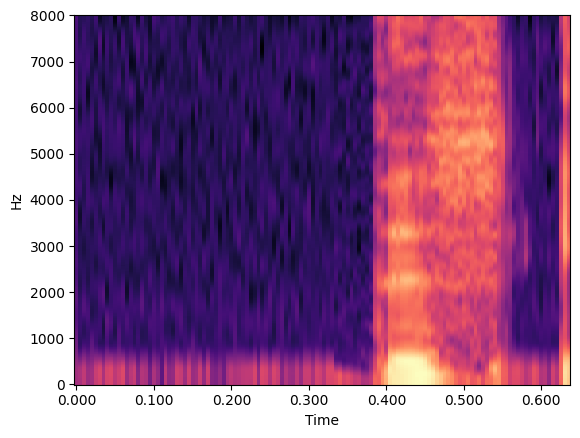

In [101]:
render_sp(source_features[2].squeeze().numpy(), 16000, 5.0)

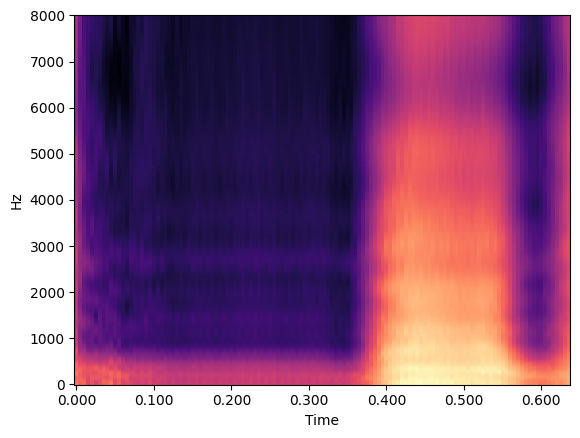

In [104]:
render_mcep_features(features=source_features, mcep=output_mcep.detach())